## Find the Missing store sales transactions

### Problem Statement
Nielsen receives transaction level scanning data (POS Data) from its partner stores on a regular basis. Stores sharing POS data include bigger format store types such as supermarkets, hypermarkets as well as smaller traditional trade grocery stores (Kirana stores), medical stores etc. using a POS machine.

While in a bigger format store, all items for all transactions are scanned using a POS machine, smaller and more localized shops do not have a 100% compliance rate in terms of scanning and inputting information into the POS machine for all transactions.

A transaction involving a single packet of chips or a single piece of candy may not be scanned and recorded to spare customer the inconvenience or during rush hours when the store is crowded with customers.

Thus, the data received from such stores is often incomplete and lacks complete information of all transactions completed within a day.

Additionally, apart from incomplete transaction data in a day, it is observed that certain stores do not share data for all active days. Stores share data ranging from 2 to 28 days in a month. While it is possible to impute/extrapolate data for 2 days of a month using 28 days of actual historical data, the vice versa is not recommended.

Nielsen encourages you to create a model which can help impute/extrapolate data to fill in the missing data gaps in the store level POS data currently received.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import  IterativeImputer
from sklearn.preprocessing import LabelEncoder

Import data from csv files

In [2]:
df_working_data = pd.read_csv("Hackathon_Working_Data.csv")

In [3]:
df_working_data.head()

,MONTH,STORECODE,DAY,BILL_ID,BILL_AMT,QTY,VALUE,PRICE,GRP,SGRP,SSGRP,CMP,MBRD,BRD
0,M1,N1,4,T375,225.0,1.0,225.0,225.0,BUTTER MARGR (4/94),BUTTER,SALTED,G C M M F,AMUL,AMUL
1,M1,N1,4,T379,95.0,1.0,95.0,95.0,CONFECTIONERY - ECLAIRS,CONFECTIONERY - ECLAIRS,CONFECTIONERY - ECLAIRS,PARLE PRODS,MELODY,MELODY CHOCOLATY
2,M1,N1,4,T381,10.0,1.0,10.0,10.0,CHOCOLATE,CHOCOLATE PANNED,CHOCOLATE PANNED,MONDELEZ INTERNATIONAL,CADBURY SHOTS,CADBURY SHOTS
3,M1,N1,4,T382,108.0,1.0,108.0,108.0,PACKAGED TEA,MAIN PACKS,MAIN PACKS,GUJ TEA PROCESSORS,WAGH BAKRI,WAGH BAKRI INSTANT
4,M1,N1,4,T384,19.0,1.0,19.0,19.0,ALL IODISED SALT,POWDERED SALT,POWDERED SALT,TATA CHEM,TATA,TATA SALT


In [4]:
df_working_data.nunique()

MONTH           3
STORECODE      10
DAY            31
BILL_ID      6424
BILL_AMT     1453
QTY            45
VALUE         640
PRICE         492
GRP            80
SGRP          174
SSGRP         232
CMP           354
MBRD          643
BRD          1315
dtype: int64

We have 3 months of Data for 10 different store's

In [5]:
df_working_data.shape

(26985, 14)

Check for Null values

In [6]:
df_working_data.isnull().sum()

MONTH        0
STORECODE    0
DAY          0
BILL_ID      0
BILL_AMT     0
QTY          0
VALUE        0
PRICE        0
GRP          0
SGRP         0
SSGRP        0
CMP          0
MBRD         0
BRD          0
dtype: int64

No Null values

### Analysing Bill_ID column

In [7]:
df_working_data_copy = df_working_data

In [8]:
df_working_data["BILL_ID"] = df_working_data["BILL_ID"].replace({'T':''}, regex=True)

In [9]:
df_working_data.sort_values(by='BILL_ID').head()

,MONTH,STORECODE,DAY,BILL_ID,BILL_AMT,QTY,VALUE,PRICE,GRP,SGRP,SSGRP,CMP,MBRD,BRD
3661,M1,N4,1,1,331.5,1.0,68.0,68.0,RUBEFACIENT,RUBEFACIENT,RUBEFACIENT,GLAXO SMITHKLINE,IODEX,IODEX
3656,M1,N4,1,1,331.5,1.0,26.0,26.0,WASHING POWDERS/LIQUIDS,WASHING POWDERS/LIQUIDS,WASHING POWDERS/LIQUIDS,HINDUSTAN UNILEVER LIMITED,WHEEL,WHEEL GREEN
3655,M1,N4,1,1,331.5,1.0,104.0,104.0,TOILET SOAPS (04/00),PREMIUM,PREMIUM,RECKITT BENCKISER,DETTOL,DETTOL COOL
3659,M1,N4,1,1,331.5,2.0,19.0,9.5,BISCUITS - CORE & NON CORE,GLUCOSE,GLUCOSE,PARLE PRODS,PARLE-G,PARLE-G
3660,M1,N4,1,1,331.5,5.0,47.5,9.5,BISCUITS - CORE & NON CORE,MARIE,MARIE,BRITANNIA INDS,MARIE GOLD,MARIE GOLD REGULAR


Find the missing BILL_ID in the series

In [10]:
df_working_data['BILL_ID'].max()

'999'

In [11]:
df_working_data['BILL_ID'].min()

'1'

In [12]:
missing_ids = [id for id in range(1,1000) if id not in df_working_data['BILL_ID']] 

In [13]:
missing_ids

[]

No missing ID's so we can get rid of the column 'BILL_ID'

In [14]:
df_working_data.head()

,MONTH,STORECODE,DAY,BILL_ID,BILL_AMT,QTY,VALUE,PRICE,GRP,SGRP,SSGRP,CMP,MBRD,BRD
0,M1,N1,4,375,225.0,1.0,225.0,225.0,BUTTER MARGR (4/94),BUTTER,SALTED,G C M M F,AMUL,AMUL
1,M1,N1,4,379,95.0,1.0,95.0,95.0,CONFECTIONERY - ECLAIRS,CONFECTIONERY - ECLAIRS,CONFECTIONERY - ECLAIRS,PARLE PRODS,MELODY,MELODY CHOCOLATY
2,M1,N1,4,381,10.0,1.0,10.0,10.0,CHOCOLATE,CHOCOLATE PANNED,CHOCOLATE PANNED,MONDELEZ INTERNATIONAL,CADBURY SHOTS,CADBURY SHOTS
3,M1,N1,4,382,108.0,1.0,108.0,108.0,PACKAGED TEA,MAIN PACKS,MAIN PACKS,GUJ TEA PROCESSORS,WAGH BAKRI,WAGH BAKRI INSTANT
4,M1,N1,4,384,19.0,1.0,19.0,19.0,ALL IODISED SALT,POWDERED SALT,POWDERED SALT,TATA CHEM,TATA,TATA SALT


If we look closely we can see that Bill Amount is the total bill for a customer, as it has multiple entries in the table. <br> As we need the sales data at the GRP Level we can also drop the column. <br>
However this can be used for different sales analyses, but we can skip it for the given problem statement.

In [15]:
df_working_data.drop(['BILL_ID','BILL_AMT'], axis=1, inplace=True)
df_working_data.head()

,MONTH,STORECODE,DAY,QTY,VALUE,PRICE,GRP,SGRP,SSGRP,CMP,MBRD,BRD
0,M1,N1,4,1.0,225.0,225.0,BUTTER MARGR (4/94),BUTTER,SALTED,G C M M F,AMUL,AMUL
1,M1,N1,4,1.0,95.0,95.0,CONFECTIONERY - ECLAIRS,CONFECTIONERY - ECLAIRS,CONFECTIONERY - ECLAIRS,PARLE PRODS,MELODY,MELODY CHOCOLATY
2,M1,N1,4,1.0,10.0,10.0,CHOCOLATE,CHOCOLATE PANNED,CHOCOLATE PANNED,MONDELEZ INTERNATIONAL,CADBURY SHOTS,CADBURY SHOTS
3,M1,N1,4,1.0,108.0,108.0,PACKAGED TEA,MAIN PACKS,MAIN PACKS,GUJ TEA PROCESSORS,WAGH BAKRI,WAGH BAKRI INSTANT
4,M1,N1,4,1.0,19.0,19.0,ALL IODISED SALT,POWDERED SALT,POWDERED SALT,TATA CHEM,TATA,TATA SALT


In [16]:
df_working_data_copy = df_working_data

## I. Extracting the details for missing record/days

1. Get the list of Month's we have in working data

In [17]:
month_list = df_working_data['MONTH'].unique()
month_list

array(['M1', 'M2', 'M3'], dtype=object)

2. Get the list of Store Code we have in working data

In [18]:
store_list = df_working_data['STORECODE'].unique()
store_list

array(['N1', 'N2', 'N3', 'N4', 'N5', 'N6', 'N7', 'N8', 'N9', 'N10'],
      dtype=object)

3. Get the list of missing days for each store for all 3 months

In [19]:
missing_date_list = []
for store in store_list:
    for month in month_list:
        date_list = df_working_data.loc[(df_working_data['MONTH']== month) & (df_working_data['STORECODE']==store)]['DAY'].unique()
        final_date_list = [i for i in range(1,30) if i not in date_list]
        missing_date_list.append(final_date_list)
print(missing_date_list)

[[1, 2, 3, 18, 19, 22, 23, 24, 27], [8, 10, 14, 18, 19, 20, 21, 23, 26, 29], [1, 21, 22, 24], [7, 14, 19, 21, 23, 27, 28], [5, 10, 11, 12, 16, 18, 19, 20, 23, 25, 26], [2, 7, 8, 9, 11, 13, 16, 20, 23, 27, 29], [2, 6, 7, 8, 10, 22, 23, 26, 27], [1, 6, 8, 9, 14, 23, 26, 28], [2, 5, 7, 12, 14, 19, 22, 23, 25, 29], [12, 13, 15, 17, 18, 19, 20, 21, 22, 25, 27], [9, 15, 19, 20, 22, 26, 27], [6, 22], [1, 11, 16, 18, 19, 23, 25, 26, 27], [1, 7, 8, 14, 18, 22, 24, 26], [1, 4, 6, 21, 26, 27], [4, 5, 6, 7, 8, 9, 13, 16, 17, 18, 20, 25], [3, 11, 18, 20, 21, 23, 24, 26, 27], [3, 15, 16, 17, 18, 20, 25, 26], [6, 9, 10, 11, 14, 16, 22, 24], [1, 2, 14, 16], [1, 6, 7, 11, 14, 16, 17, 19, 22, 26], [4, 6, 9, 14, 16, 28, 29], [2, 3, 9, 11, 13, 16, 19, 23, 27], [10, 13, 15, 23, 25, 29], [1, 5, 10, 13, 15, 21, 24, 27], [7, 14, 15, 18, 22, 23, 25, 28, 29], [4, 8, 10, 13, 15, 16, 21, 22, 23, 24, 25, 26, 27, 28, 29], [4, 6, 23, 28], [1, 6, 9, 10, 12, 16, 22], [14, 16, 19, 21, 22]]


Now we have the dates for which records are missing for each Store and each Month

Apart from the Data for the above dates, we have some more missing data, as stated in the problem statement. <br>
i.e. A transaction involving a single packet of chips or a single piece of candy may not be scanned and recorded to spare customer the inconvenience or during rush hours when the store is crowded with customers.

## II. Find Busiest days by grouping everyday sales

By finding the sales pattern we can get the days which would have rush hours and could have led to the missing record for smaller items

#### Date wise Sale for each store(for all 3 months)

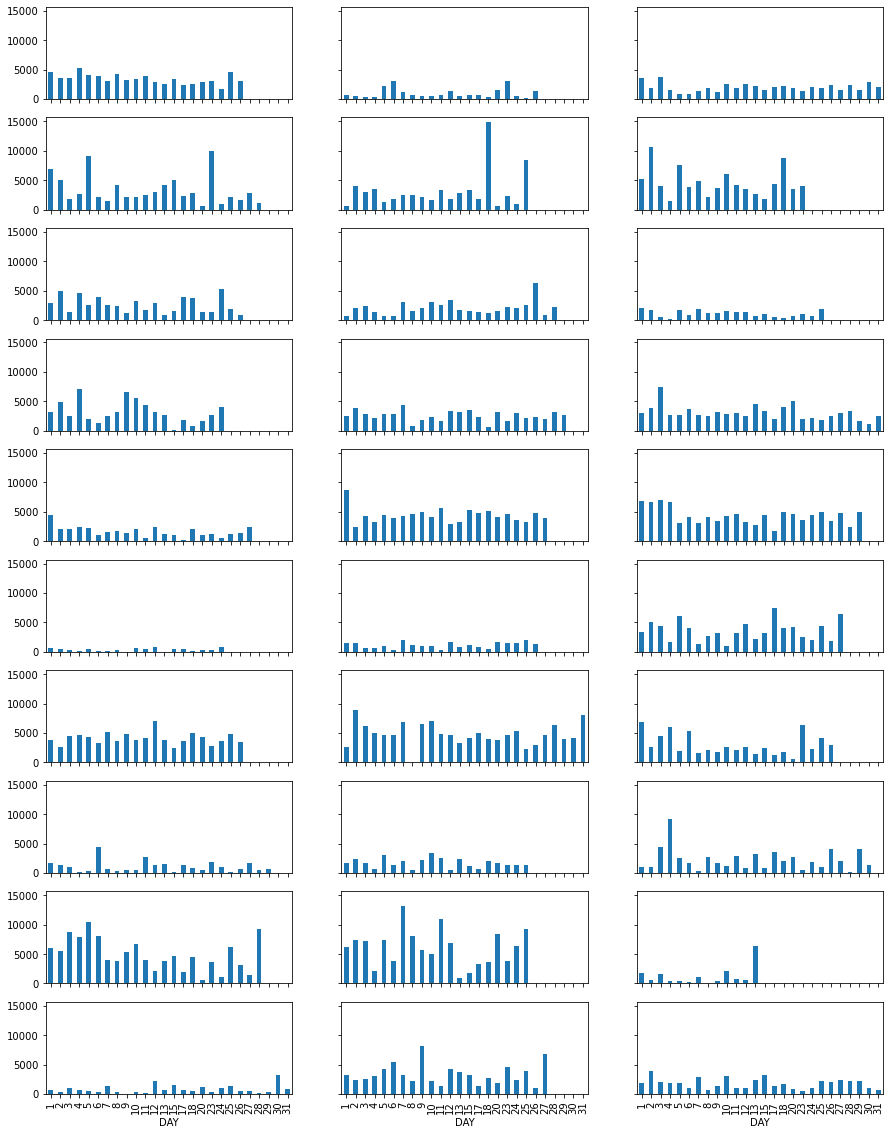

In [20]:
f, axes = plt.subplots(10, 3, figsize=(15, 20), sharex=True, sharey=True)
for i,store in enumerate(store_list):
    for j,month in enumerate(month_list):
        df_sample_1 = df_working_data.loc[(df_working_data['MONTH']== month) & (df_working_data['STORECODE']==store)]
        df_sample_1.groupby('DAY').sum()['VALUE'].plot.bar(ax= axes[i,j])

#### Number of records per day/No of different items sold per day

Note: Considering groupby on Day, but can also consider groupby on the day and have a group based on unique bill id or consider the quantity

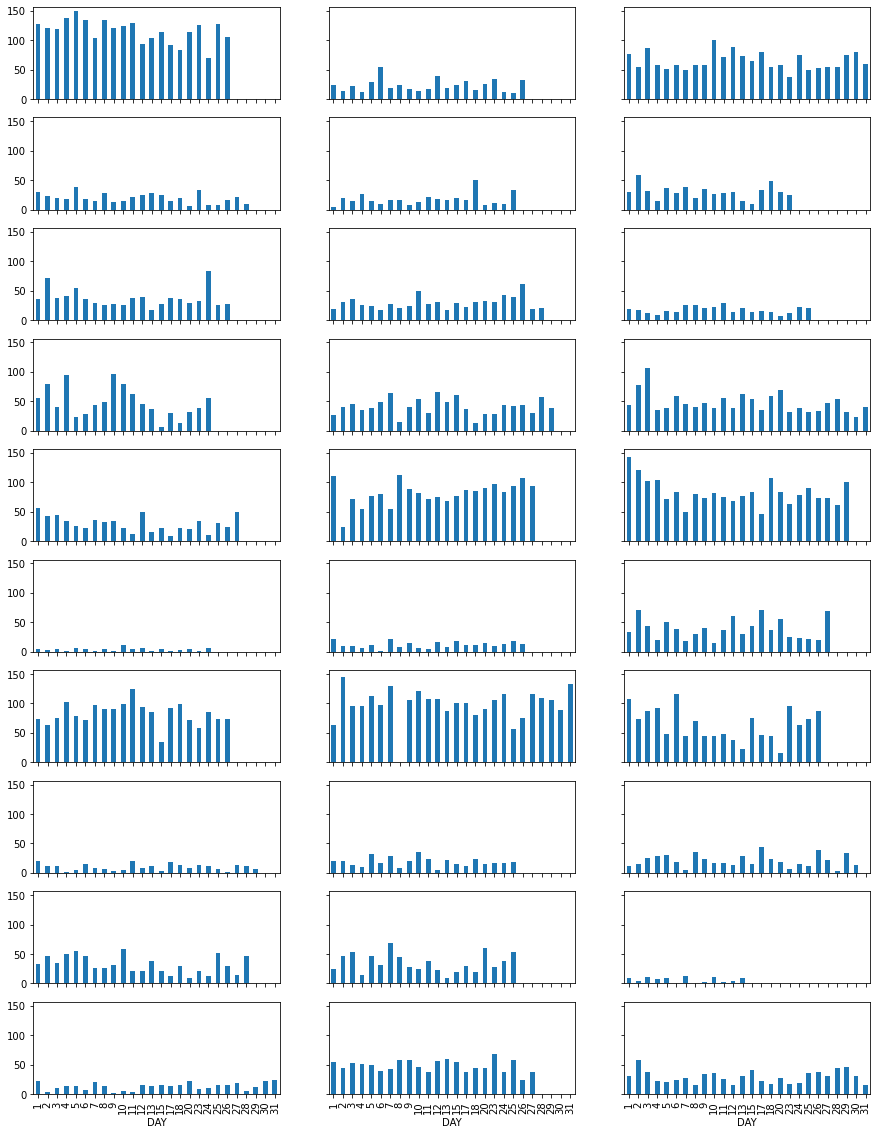

In [21]:
f, axes = plt.subplots(10, 3, figsize=(15, 20), sharex=True, sharey=True)
for i,store in enumerate(store_list):
    for j,month in enumerate(month_list):
        df_sample_1 = df_working_data.loc[(df_working_data['MONTH']== month) & (df_working_data['STORECODE']==store)]
        df_sample_1.groupby('DAY').count()['MONTH'].plot.bar(ax= axes[i,j])

#### List of the busiest day in the month

Looking at the above graph, we see the number of transactions per day varies for all 10 stores but the Variance is less if we consider data of a particular  store in a given month.<br> 
We can consider a different cutoff value for each store. <br>
We can either use a hardcoded value or we can calculate the days when the sale was 90% more than other days(for all 3 months).

In [22]:
busiest_days = []
for store in store_list:
    for month in month_list:
        df_new = df_working_data.loc[(df_working_data['MONTH']== month) &
                                             (df_working_data['STORECODE']==store)].groupby('DAY').count()['MONTH']
        final_date_list = [i for i in df_new.keys() if i in df_new.nlargest(3)]
        busiest_days.append(final_date_list)
        #print(df_new.nlargest(3

In [23]:
busiest_days

[[7, 8, 9],
 [6, 15, 27],
 [4, 11, 13],
 [1, 5, 22],
 [4, 27, 31],
 [3, 12, 25],
 [3, 9, 28],
 [15, 25, 29],
 [10, 11, 16],
 [4, 9, 10],
 [7, 13, 16],
 [2, 3, 18],
 [2, 14, 31],
 [2, 11, 29],
 [2, 3, 19],
 [11, 21, 31],
 [1, 8, 16],
 [2, 21, 31],
 [4, 15, 17],
 [4, 9, 30],
 [2, 9, 28],
 [1, 15, 20],
 [7, 10, 15],
 [8, 18, 26],
 [7, 14, 28],
 [8, 21, 27],
 [3, 9, 14],
 [1, 29, 30],
 [19, 25, 27],
 [2, 28, 29]]

Now, we have the list of the top 10% busiest days

## III. Calculating the number of entries needs to add for the missing days

We can consider the <b>Mean</b> of "number of transactions" for the month at a particular store to get the number of new records that need to be added.<br>
The same need's to be calculated for every shop every month.

In [24]:
mean_list = []
for store in store_list:
    for month in month_list:
        mean_list.append(int(df_working_data.loc[(df_working_data['MONTH']== month) &
                                             (df_working_data['STORECODE']==store)].groupby('DAY').count()['MONTH'].mean()))

In [25]:
mean_list

[115,
 23,
 64,
 19,
 17,
 29,
 37,
 29,
 17,
 48,
 40,
 47,
 29,
 81,
 83,
 3,
 12,
 38,
 82,
 98,
 63,
 9,
 18,
 20,
 32,
 35,
 6,
 13,
 47,
 29]

Now, we have the number of rows that we need to create for missing dates

### Possible Model Creation check

We have "MONTH", "STORECODE", "DAY" for each of the new entry we want to create. We need to have a model to predict a product  based on column <b>"BRD"</b>
<br> But if we use Mode imputation technique on Column "BRD", this will result to the same item every time, so we cannot use Mode.
<br> If we try using a model(i.e. KNN) that will have the same problem as in case of Mode.

A possible solution could be as:
1. Get the number of rows we have to create for a specific date(i.e 100)
2. We can then find 100 most sold items(i.e. BRD) for that month at a particular store.
3. Fill the values based on those 100 selected rows.
<br>This has a side effect that for all the days missing in a specific month will get the same entries.

### Data availability Check

We have the following information:
1. List of 'days' for which entries are missing for each store each month. (missing_date_list)
2. Top 10% busiest days for every store for each month. (busiest_days)
3. We have the Number of rows that we need to add for the missing days. (mean_list)
4. No of records we need to add for 10% busiest days. - Pending

## IV. Calculating the number of entries needed for Busy days

1. Create Null rows for busy days

In [26]:
# We have the list of busiest days
busiest_days

[[7, 8, 9],
 [6, 15, 27],
 [4, 11, 13],
 [1, 5, 22],
 [4, 27, 31],
 [3, 12, 25],
 [3, 9, 28],
 [15, 25, 29],
 [10, 11, 16],
 [4, 9, 10],
 [7, 13, 16],
 [2, 3, 18],
 [2, 14, 31],
 [2, 11, 29],
 [2, 3, 19],
 [11, 21, 31],
 [1, 8, 16],
 [2, 21, 31],
 [4, 15, 17],
 [4, 9, 30],
 [2, 9, 28],
 [1, 15, 20],
 [7, 10, 15],
 [8, 18, 26],
 [7, 14, 28],
 [8, 21, 27],
 [3, 9, 14],
 [1, 29, 30],
 [19, 25, 27],
 [2, 28, 29]]

In [27]:
df_busy_rows = pd.DataFrame(columns=df_working_data.columns)

In [28]:
def get_range(store, month, day):
    count = df_working_data.loc[(df_working_data['MONTH']== month) &
                            (df_working_data['STORECODE']== store) &
                            (df_working_data['DAY']== day)].groupby('DAY').count()['MONTH'].get(day)
    return count

In [29]:
index = 0
for store in store_list:
    for month in month_list:
        for day in busiest_days[index]:
            new_record = {"MONTH":month, "STORECODE":store,"DAY":day,"QTY":np.nan,
                       "VALUE":np.nan, "PRICE":np.nan, "GRP":np.nan, "SGRP":np.nan,
                       "SSGRP":np.nan, "CMP":np.nan, "MBRD":np.nan, "BRD":np.nan}
            count = int((get_range(store, month, day).item())/int(10))
            for i in range(count):
                df_busy_rows = df_busy_rows.append(new_record, ignore_index=True)
        index = index +1

In [30]:
df_busy_rows.head()

,MONTH,STORECODE,DAY,QTY,VALUE,PRICE,GRP,SGRP,SSGRP,CMP,MBRD,BRD
0,M1,N1,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,M1,N1,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,M1,N1,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,M1,N1,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,M1,N1,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
df_busy_rows.shape

(518, 12)

Now we have the Dataframe ready for the missing data on busy days

2. Get values for to fill df_busy_list

We will fill with smaller products i.e chips and biscuits with quantity as 1.

In [32]:
df_working_data['GRP'].unique()

array(['BUTTER MARGR  (4/94)', 'CONFECTIONERY - ECLAIRS', 'CHOCOLATE',
       'PACKAGED TEA', 'ALL IODISED SALT', 'READY TO EAT',
       'SALTY SNACKS (2/97)', 'BISCUITS - CORE & NON CORE',
       'SPICES (03/04)', 'PRE-POST WASH PRODUCTS', 'MILK POWDERS',
       'SHAMPOO - BY SEGMENTS', 'VERMICELLI & NOODLE',
       'CONFECTIONERY - TOFFEE/HBC', 'CLEANERS - FLOOR',
       'DIAPERS       (8/93)', 'TOOTH PASTES', 'TOILET SOAPS (04/00)',
       'WASHING POWDERS/LIQUIDS', 'DETERGENT CAKES/BARS', 'BEVERAGES',
       'ANTACIDS', 'ALL AIR FRESHNERS(01/03)',
       'REFINED EDIBLE OILS-ALL PACKS', 'CLEANERS - UTENSIL',
       'CONFECTIONERY - LOLLIPOP/FMR', 'HOME INSECTICIDES CTG  (8/93)',
       'PACKAGED ATTA (1/95)', 'BREAKFAST CEREALS',
       'HAIR OILS PKTP(8/02)', 'KETCHUPS/SAUCES', 'CHEESE        (4/94)',
       'COCONUT OIL PKTYP (08/02)', 'TOOTH BRUSH   (7/93)',
       'VANASPATI CONS PACK (8/94)', 'AGARBATTI & DHOOPBATTI',
       'SQSH CRDLS & SFT DRNK-CONVERTD', 'SKIN CREAMS',
   

In the above list we see "CHOCOLATE" and "SALTY SNACKS (2/97)", these are the items mostly sold without being scanned.<br>
In order to get more precise, we can consider the Chocolate and snacks with less cost and the most popular does not get recorded.

We can use the Mode imputation technique to fill the newly added rows with a condition that GRP belongs to CHOCOLATE or SALTY SNACKS

In [33]:
small_items = df_working_data.loc[(df_working_data['GRP'] == 'CHOCOLATE') | (df_working_data['GRP'] == 'SALTY SNACKS (2/97)')]

In [34]:
small_items.head()

,MONTH,STORECODE,DAY,QTY,VALUE,PRICE,GRP,SGRP,SSGRP,CMP,MBRD,BRD
2,M1,N1,4,1.0,10.0,10.0,CHOCOLATE,CHOCOLATE PANNED,CHOCOLATE PANNED,MONDELEZ INTERNATIONAL,CADBURY SHOTS,CADBURY SHOTS
5,M1,N1,4,1.0,10.0,10.0,CHOCOLATE,MOULDED,MOULDED,MONDELEZ INTERNATIONAL,CADBURY DAIRY MILK,DAIRY MILK
7,M1,N1,4,1.0,5.0,5.0,CHOCOLATE,COATED WAFER BISC,COATED WAFER BISC,GANDOUR INDIA FOOD PROCESSING,GANDOUR,GANDOUR
8,M1,N1,4,1.0,10.0,10.0,SALTY SNACKS (2/97),POTATO WAFERS,POTATO WAFERS,PEPSICO INDIA,LAYS,LAYS AMERICAN STYLE
9,M1,N1,4,1.0,10.0,10.0,SALTY SNACKS (2/97),POTATO WAFERS,POTATO WAFERS,PEPSICO INDIA,LAYS,LAYS CARIBBEAN STYLE


Now we have items with GRP as "CHOCOLATE" and "SALTY SNACKS (2/97)", now we can further sort the data based on price and select top N records. N is the no of new rows
<br> Note: We can also find unique items and sort based on the popularity(i.e. having more records) and then use Top N from it.

In [35]:
small_items_list = small_items.nsmallest(len(df_busy_rows.index),"PRICE")

In [36]:
small_items_list.reset_index(inplace=True,drop=True)

In [37]:
small_items_list.head()

,MONTH,STORECODE,DAY,QTY,VALUE,PRICE,GRP,SGRP,SSGRP,CMP,MBRD,BRD
0,M1,N4,11,15.0,71.25,4.75,SALTY SNACKS (2/97),DAL,DAL,BALAJI WAFERS P L,BALAJI,BALAJI MOONG DAL
1,M1,N7,1,2.0,9.50,4.75,SALTY SNACKS (2/97),NUTS,NUTS,HALDIRAM,HALDIRAM,HALDIRAM SALTED PEANUTS
2,M1,N7,2,1.0,4.75,4.75,SALTY SNACKS (2/97),POTATO WAFERS,POTATO WAFERS,HALDIRAM,HALDIRAM,HALDIRAM MOPLEEZ
3,M1,N7,4,2.0,9.50,4.75,SALTY SNACKS (2/97),POTATO WAFERS,POTATO WAFERS,HALDIRAM,HALDIRAM,HALDIRAM MOPLEEZ
4,M1,N7,5,2.0,9.50,4.75,SALTY SNACKS (2/97),POTATO WAFERS,POTATO WAFERS,HALDIRAM,HALDIRAM,HALDIRAM MOPLEEZ


Now we have the data which we can use to impute directly

In [38]:
df_busy_rows['QTY'] = 1
for column in df_busy_rows.columns[3:]:
    df_busy_rows[column] = small_items_list[column]

In [39]:
df_busy_rows.head()

,MONTH,STORECODE,DAY,QTY,VALUE,PRICE,GRP,SGRP,SSGRP,CMP,MBRD,BRD
0,M1,N1,7,15.0,71.25,4.75,SALTY SNACKS (2/97),DAL,DAL,BALAJI WAFERS P L,BALAJI,BALAJI MOONG DAL
1,M1,N1,7,2.0,9.50,4.75,SALTY SNACKS (2/97),NUTS,NUTS,HALDIRAM,HALDIRAM,HALDIRAM SALTED PEANUTS
2,M1,N1,7,1.0,4.75,4.75,SALTY SNACKS (2/97),POTATO WAFERS,POTATO WAFERS,HALDIRAM,HALDIRAM,HALDIRAM MOPLEEZ
3,M1,N1,7,2.0,9.50,4.75,SALTY SNACKS (2/97),POTATO WAFERS,POTATO WAFERS,HALDIRAM,HALDIRAM,HALDIRAM MOPLEEZ
4,M1,N1,7,2.0,9.50,4.75,SALTY SNACKS (2/97),POTATO WAFERS,POTATO WAFERS,HALDIRAM,HALDIRAM,HALDIRAM MOPLEEZ


3. Merge the "df_busy_rows" dataframe with working data

In [40]:
df_working_data = df_working_data.append(df_busy_rows, ignore_index=True)

In [41]:
df_working_data.shape

(27503, 12)

In [42]:
df_working_data_copy2 = df_working_data

Records for missing transactions  of Busy day is added.

## V. Create Records for missing days

### Type 1. By finding similar rows and replacing rows

Get rows based on the mean list to fill in the values in df_new_records dataframe

Most sold item of all time independent of store or month

In [43]:
df_working_data['BRD'].mode()

0    MARIE GOLD REGULAR
dtype: object

Most sold item at Store N1 in the Month M1

In [44]:
df_working_data.loc[(df_working_data['MONTH']== 'M1') &
                            (df_working_data['STORECODE']== 'N1')]['BRD'].mode()

0    DAIRY MILK
dtype: object

Top 5 Items sold across all stores

In [45]:
df_working_data['BRD'].value_counts()[:5].index.tolist()

['MARIE GOLD REGULAR', 'AMUL', 'EVEREST', 'MAGGI MASALA', 'PARLE-G']

In [46]:
# We have the list of days for which we need to create transactions
missing_date_list

[[1, 2, 3, 18, 19, 22, 23, 24, 27],
 [8, 10, 14, 18, 19, 20, 21, 23, 26, 29],
 [1, 21, 22, 24],
 [7, 14, 19, 21, 23, 27, 28],
 [5, 10, 11, 12, 16, 18, 19, 20, 23, 25, 26],
 [2, 7, 8, 9, 11, 13, 16, 20, 23, 27, 29],
 [2, 6, 7, 8, 10, 22, 23, 26, 27],
 [1, 6, 8, 9, 14, 23, 26, 28],
 [2, 5, 7, 12, 14, 19, 22, 23, 25, 29],
 [12, 13, 15, 17, 18, 19, 20, 21, 22, 25, 27],
 [9, 15, 19, 20, 22, 26, 27],
 [6, 22],
 [1, 11, 16, 18, 19, 23, 25, 26, 27],
 [1, 7, 8, 14, 18, 22, 24, 26],
 [1, 4, 6, 21, 26, 27],
 [4, 5, 6, 7, 8, 9, 13, 16, 17, 18, 20, 25],
 [3, 11, 18, 20, 21, 23, 24, 26, 27],
 [3, 15, 16, 17, 18, 20, 25, 26],
 [6, 9, 10, 11, 14, 16, 22, 24],
 [1, 2, 14, 16],
 [1, 6, 7, 11, 14, 16, 17, 19, 22, 26],
 [4, 6, 9, 14, 16, 28, 29],
 [2, 3, 9, 11, 13, 16, 19, 23, 27],
 [10, 13, 15, 23, 25, 29],
 [1, 5, 10, 13, 15, 21, 24, 27],
 [7, 14, 15, 18, 22, 23, 25, 28, 29],
 [4, 8, 10, 13, 15, 16, 21, 22, 23, 24, 25, 26, 27, 28, 29],
 [4, 6, 23, 28],
 [1, 6, 9, 10, 12, 16, 22],
 [14, 16, 19, 21, 22]]

In [47]:
result_df = pd.DataFrame(columns=df_working_data.columns)

In [48]:
result_df.head()

,MONTH,STORECODE,DAY,QTY,VALUE,PRICE,GRP,SGRP,SSGRP,CMP,MBRD,BRD


In [49]:
mean_list_counter = 0
index=0
rows_to_insert = pd.DataFrame(columns=df_working_data.columns)
for store in store_list:
    for month in month_list:
        list_of_items= df_working_data.loc[(df_working_data['MONTH']== month) &
                            (df_working_data['STORECODE']== store)]['BRD'].value_counts()[:mean_list[mean_list_counter]].index.tolist()
        for day in missing_date_list[index]:   
            rows_to_insert = df_working_data.loc[df_working_data['BRD'].isin(list_of_items)].head(mean_list[mean_list_counter])
            rows_to_insert['DAY'] = day
            result_df = result_df.append(rows_to_insert, ignore_index=True)
            rows_to_insert.iloc[0:0]
        index +=1
        mean_list_counter += 1    

In [50]:
result_df.head()

,MONTH,STORECODE,DAY,QTY,VALUE,PRICE,GRP,SGRP,SSGRP,CMP,MBRD,BRD
0,M1,N1,1,1.0,225.0,225.0,BUTTER MARGR (4/94),BUTTER,SALTED,G C M M F,AMUL,AMUL
1,M1,N1,1,1.0,10.0,10.0,CHOCOLATE,CHOCOLATE PANNED,CHOCOLATE PANNED,MONDELEZ INTERNATIONAL,CADBURY SHOTS,CADBURY SHOTS
2,M1,N1,1,1.0,19.0,19.0,ALL IODISED SALT,POWDERED SALT,POWDERED SALT,TATA CHEM,TATA,TATA SALT
3,M1,N1,1,1.0,10.0,10.0,CHOCOLATE,MOULDED,MOULDED,MONDELEZ INTERNATIONAL,CADBURY DAIRY MILK,DAIRY MILK
4,M1,N1,1,1.0,5.0,5.0,CHOCOLATE,COATED WAFER BISC,COATED WAFER BISC,GANDOUR INDIA FOOD PROCESSING,GANDOUR,GANDOUR


In [51]:
result_df.shape

(8862, 12)

Set of New transactions for all missing dates are ready, we can now merge the same to working data.

In [52]:
df_working_data = df_working_data.append(result_df, ignore_index=True)

In [53]:
df_working_data.shape

(36365, 12)

## Type 2: Using Sklearn Imputer : IterativeImputer

Create Null rows, data for missing dates

In [54]:
df_new_records = pd.DataFrame(columns=df_working_data.columns)

In [55]:
df_new_records.head()

,MONTH,STORECODE,DAY,QTY,VALUE,PRICE,GRP,SGRP,SSGRP,CMP,MBRD,BRD


In [56]:
index = 0
for store in store_list:
    for month in month_list:
        for day in missing_date_list[index]:
            new_record = {"MONTH":month, "STORECODE":store,"DAY":day,"QTY":np.nan,
                       "VALUE":np.nan, "PRICE":np.nan, "GRP":np.nan, "SGRP":np.nan,
                       "SSGRP":np.nan, "CMP":np.nan, "MBRD":np.nan, "BRD":np.nan}
            for i in range(mean_list[index]):
                df_new_records = df_new_records.append(new_record, ignore_index=True)
        index = index +1

In [57]:
df_new_records.head()

,MONTH,STORECODE,DAY,QTY,VALUE,PRICE,GRP,SGRP,SSGRP,CMP,MBRD,BRD
0,M1,N1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,M1,N1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,M1,N1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,M1,N1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,M1,N1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [58]:
df_working_data_copy2.head()

,MONTH,STORECODE,DAY,QTY,VALUE,PRICE,GRP,SGRP,SSGRP,CMP,MBRD,BRD
0,M1,N1,4,1.0,225.0,225.0,BUTTER MARGR (4/94),BUTTER,SALTED,G C M M F,AMUL,AMUL
1,M1,N1,4,1.0,95.0,95.0,CONFECTIONERY - ECLAIRS,CONFECTIONERY - ECLAIRS,CONFECTIONERY - ECLAIRS,PARLE PRODS,MELODY,MELODY CHOCOLATY
2,M1,N1,4,1.0,10.0,10.0,CHOCOLATE,CHOCOLATE PANNED,CHOCOLATE PANNED,MONDELEZ INTERNATIONAL,CADBURY SHOTS,CADBURY SHOTS
3,M1,N1,4,1.0,108.0,108.0,PACKAGED TEA,MAIN PACKS,MAIN PACKS,GUJ TEA PROCESSORS,WAGH BAKRI,WAGH BAKRI INSTANT
4,M1,N1,4,1.0,19.0,19.0,ALL IODISED SALT,POWDERED SALT,POWDERED SALT,TATA CHEM,TATA,TATA SALT


Add the newly created rows to working data

In [59]:
df_working_data_copy2 = df_working_data_copy2.append(df_new_records, ignore_index=True)

In [60]:
df_working_data_copy2.shape

(36365, 12)

1. Handling the categorical  columns

In [61]:
encoder = LabelEncoder()

In [62]:
cat_cols = ['MONTH','STORECODE','GRP','SGRP','SSGRP','CMP','MBRD','BRD']

In [63]:
def encode(data):
    '''function to encode non-null data and replace it in the original data'''
    nonulls = np.array(data.dropna())
    impute_reshape = nonulls.reshape(-1,1)
    impute_ordinal = encoder.fit_transform(impute_reshape)
    data.loc[data.notnull()] = np.squeeze(impute_ordinal)
    return data

In [64]:
for columns in cat_cols:
    encode(df_working_data_copy2[columns])

C:\Users\Aashish\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Aashish\anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [65]:
df_working_data_copy2.head()

,MONTH,STORECODE,DAY,QTY,VALUE,PRICE,GRP,SGRP,SSGRP,CMP,MBRD,BRD
0,0,0,4,1.0,225.0,225.0,14,25,191,90,18,39
1,0,0,4,1.0,95.0,95.0,26,40,51,233,345,783
2,0,0,4,1.0,10.0,10.0,16,32,42,206,66,142
3,0,0,4,1.0,108.0,108.0,52,88,119,114,624,1277
4,0,0,4,1.0,19.0,19.0,3,121,169,315,578,1197


In [66]:
df_working_data_copy2.isnull().sum()

MONTH           0
STORECODE       0
DAY             0
QTY          8862
VALUE        8862
PRICE        8862
GRP          8862
SGRP         8862
SSGRP        8862
CMP          8862
MBRD         8862
BRD          8862
dtype: int64

All the categorical columns are now encoded and we have the null values for which we need to build imputation model

2. Create imputer object , fit and transform data

In [67]:
 imputer = IterativeImputer(missing_values=np.nan,
                               random_state=0,initial_strategy='most_frequent')

In [68]:
imputer.fit(df_working_data_copy2)

IterativeImputer(initial_strategy='most_frequent', random_state=0)

In [69]:
df_working_data_imputed = imputer.transform(df_working_data_copy2)

In [70]:
df_working_data_imputed

array([[  0.        ,   0.        ,   4.        , ...,  90.        ,
         18.        ,  39.        ],
       [  0.        ,   0.        ,   4.        , ..., 233.        ,
        345.        , 783.        ],
       [  0.        ,   0.        ,   4.        , ..., 206.        ,
         66.        , 142.        ],
       ...,
       [  2.        ,   1.        ,  22.        , ..., 169.30853839,
        334.89291979, 706.26465232],
       [  2.        ,   1.        ,  22.        , ..., 169.30853839,
        334.89291979, 706.26465232],
       [  2.        ,   1.        ,  22.        , ..., 169.30853839,
        334.89291979, 706.26465232]])

In [71]:
df_final_data = pd.DataFrame(df_working_data_imputed,columns=df_working_data_copy2.columns)

In [72]:
df_final_data.head()

,MONTH,STORECODE,DAY,QTY,VALUE,PRICE,GRP,SGRP,SSGRP,CMP,MBRD,BRD
0,0.0,0.0,4.0,1.0,225.0,225.0,14.0,25.0,191.0,90.0,18.0,39.0
1,0.0,0.0,4.0,1.0,95.0,95.0,26.0,40.0,51.0,233.0,345.0,783.0
2,0.0,0.0,4.0,1.0,10.0,10.0,16.0,32.0,42.0,206.0,66.0,142.0
3,0.0,0.0,4.0,1.0,108.0,108.0,52.0,88.0,119.0,114.0,624.0,1277.0
4,0.0,0.0,4.0,1.0,19.0,19.0,3.0,121.0,169.0,315.0,578.0,1197.0


In [73]:
df_final_data['STORECODE'].unique()

array([0., 2., 3., 4., 5., 6., 7., 8., 9., 1.])

In [74]:
df_final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36365 entries, 0 to 36364
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   MONTH      36365 non-null  float64
 1   STORECODE  36365 non-null  float64
 2   DAY        36365 non-null  float64
 3   QTY        36365 non-null  float64
 4   VALUE      36365 non-null  float64
 5   PRICE      36365 non-null  float64
 6   GRP        36365 non-null  float64
 7   SGRP       36365 non-null  float64
 8   SSGRP      36365 non-null  float64
 9   CMP        36365 non-null  float64
 10  MBRD       36365 non-null  float64
 11  BRD        36365 non-null  float64
dtypes: float64(12)
memory usage: 3.3 MB


In [75]:
df_final_data['MONTH'] = df_final_data['MONTH'].astype(np.int64)
df_final_data['STORECODE'] = df_final_data['STORECODE'].astype(np.int64)
df_final_data['DAY'] = df_final_data['DAY'].astype(np.int64)
df_final_data['GRP'] = df_final_data['GRP'].astype(np.int64)

In [76]:
df_final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36365 entries, 0 to 36364
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   MONTH      36365 non-null  int64  
 1   STORECODE  36365 non-null  int64  
 2   DAY        36365 non-null  int64  
 3   QTY        36365 non-null  float64
 4   VALUE      36365 non-null  float64
 5   PRICE      36365 non-null  float64
 6   GRP        36365 non-null  int64  
 7   SGRP       36365 non-null  float64
 8   SSGRP      36365 non-null  float64
 9   CMP        36365 non-null  float64
 10  MBRD       36365 non-null  float64
 11  BRD        36365 non-null  float64
dtypes: float64(8), int64(4)
memory usage: 3.3 MB


In [77]:
df_final_data.head()

,MONTH,STORECODE,DAY,QTY,VALUE,PRICE,GRP,SGRP,SSGRP,CMP,MBRD,BRD
0,0,0,4,1.0,225.0,225.0,14,25.0,191.0,90.0,18.0,39.0
1,0,0,4,1.0,95.0,95.0,26,40.0,51.0,233.0,345.0,783.0
2,0,0,4,1.0,10.0,10.0,16,32.0,42.0,206.0,66.0,142.0
3,0,0,4,1.0,108.0,108.0,52,88.0,119.0,114.0,624.0,1277.0
4,0,0,4,1.0,19.0,19.0,3,121.0,169.0,315.0,578.0,1197.0


In [78]:
df_final_data.isnull().sum()

MONTH        0
STORECODE    0
DAY          0
QTY          0
VALUE        0
PRICE        0
GRP          0
SGRP         0
SSGRP        0
CMP          0
MBRD         0
BRD          0
dtype: int64

All new rows have scuccessfully imputed

## VI. Getting the Total for each entry in Validation Data

### Using results from Type 1

import validation data

In [79]:
df_validation_2 = pd.read_csv("Hackathon_Validation_Data.csv")
df_validation_2.head()

,ID,STORECODE,MONTH,GRP
0,1112535,N1,M1,AFTER SHAVE LOTIONS
1,1112539,N1,M1,AGARBATTI & DHOOPBATTI
2,1112543,N1,M1,ALL AIR FRESHNERS(01/03)
3,1112547,N1,M1,ALL IODISED SALT
4,1112551,N1,M1,ANTACIDS


Final data to be used

In [80]:
df_working_data.head()

,MONTH,STORECODE,DAY,QTY,VALUE,PRICE,GRP,SGRP,SSGRP,CMP,MBRD,BRD
0,M1,N1,4,1.0,225.0,225.0,BUTTER MARGR (4/94),BUTTER,SALTED,G C M M F,AMUL,AMUL
1,M1,N1,4,1.0,95.0,95.0,CONFECTIONERY - ECLAIRS,CONFECTIONERY - ECLAIRS,CONFECTIONERY - ECLAIRS,PARLE PRODS,MELODY,MELODY CHOCOLATY
2,M1,N1,4,1.0,10.0,10.0,CHOCOLATE,CHOCOLATE PANNED,CHOCOLATE PANNED,MONDELEZ INTERNATIONAL,CADBURY SHOTS,CADBURY SHOTS
3,M1,N1,4,1.0,108.0,108.0,PACKAGED TEA,MAIN PACKS,MAIN PACKS,GUJ TEA PROCESSORS,WAGH BAKRI,WAGH BAKRI INSTANT
4,M1,N1,4,1.0,19.0,19.0,ALL IODISED SALT,POWDERED SALT,POWDERED SALT,TATA CHEM,TATA,TATA SALT


Function to get the "Total Value" from the updated working data based on each row in validation data.

In [81]:
def get_total_data_2(row):
    total = df_working_data.loc[(df_working_data['MONTH'] == row['MONTH']) &
                                   (df_working_data['STORECODE'] == row['STORECODE']) &
                                  (df_working_data['GRP'] == row['GRP'] )]['VALUE'].sum()
    return total

Applying the above function on the validation table, and inserting the data in a new column Value

In [82]:
df_validation_2['TOTALVALUE'] = df_validation_2.apply(get_total_data_2, axis=1)

In [83]:
df_validation_2.head()

,ID,STORECODE,MONTH,GRP,TOTALVALUE
0,1112535,N1,M1,AFTER SHAVE LOTIONS,0.0
1,1112539,N1,M1,AGARBATTI & DHOOPBATTI,200.0
2,1112543,N1,M1,ALL AIR FRESHNERS(01/03),164.0
3,1112547,N1,M1,ALL IODISED SALT,10984.0
4,1112551,N1,M1,ANTACIDS,318.8


Now, we have the value column as expected, we just need to get rid of "STORECODE", "MONTH", "GRP" columns.

In [84]:
df_validation_2.drop(['STORECODE','MONTH','GRP'],axis=1, inplace=True)

In [85]:
df_validation_2.head()

,ID,TOTALVALUE
0,1112535,0.0
1,1112539,200.0
2,1112543,164.0
3,1112547,10984.0
4,1112551,318.8


In [87]:
df_validation_2.to_csv("Final_Submission_Data.csv", index=False)

In this assessment I have considered only 10% of the days in a month to be busiest, we can change the approach and consider based on the number of transactions, that way we can have more number of rows.
<br> Also in case of Missing Date I have considered the mean number of transactions for the month, we can alternatively consider the number of transaction on the previous or next day or the transaction 7 days back ( i.e. Same day the previous week

## Using results from Type 2

In [124]:
df_validation = pd.read_csv("Hackathon_Validation_Data.csv")
df_validation.head()

,ID,STORECODE,MONTH,GRP
0,1112535,N1,M1,AFTER SHAVE LOTIONS
1,1112539,N1,M1,AGARBATTI & DHOOPBATTI
2,1112543,N1,M1,ALL AIR FRESHNERS(01/03)
3,1112547,N1,M1,ALL IODISED SALT
4,1112551,N1,M1,ANTACIDS


Apply encoding to the data, as our final data set is in encoded format

In [125]:
df_validation['STORECODE'] = encoder.fit_transform(df_validation['STORECODE'])
df_validation['MONTH'] = encoder.fit_transform(df_validation['MONTH'])
df_validation['GRP'] = encoder.fit_transform(df_validation['GRP'])

In [126]:
df_validation.head()

,ID,STORECODE,MONTH,GRP
0,1112535,0,0,0
1,1112539,0,0,1
2,1112543,0,0,2
3,1112547,0,0,3
4,1112551,0,0,4


Final data to be used

In [143]:
df_final_data.head()

,MONTH,STORECODE,DAY,QTY,VALUE,PRICE,GRP,SGRP,SSGRP,CMP,MBRD,BRD
0,0,0,4,1.0,225.0,225.0,14,25.0,191.0,90.0,18.0,39.0
1,0,0,4,1.0,95.0,95.0,26,40.0,51.0,233.0,345.0,783.0
2,0,0,4,1.0,10.0,10.0,16,32.0,42.0,206.0,66.0,142.0
3,0,0,4,1.0,108.0,108.0,52,88.0,119.0,114.0,624.0,1277.0
4,0,0,4,1.0,19.0,19.0,3,121.0,169.0,315.0,578.0,1197.0


Function to get the "Total Value" from the updated working data based on each row in validation data.

In [137]:
def get_total_data(row):
    total = df_final_data.loc[(df_final_data['MONTH'] == row['MONTH']) &
                                   (df_final_data['STORECODE'] == row['STORECODE']) &
                                  (df_final_data['GRP'] == row['GRP'] )]['VALUE'].sum()
    return total

In [138]:
df_validation['TOTALVALUE'] = df_validation.apply(get_total_data, axis=1)

In [139]:
df_validation.head()

,ID,STORECODE,MONTH,GRP,TOTALVALUE
0,1112535,0,0,0,0.0
1,1112539,0,0,1,70.0
2,1112543,0,0,2,164.0
3,1112547,0,0,3,545.0
4,1112551,0,0,4,70.8


In [140]:
df_validation.drop(['STORECODE','MONTH','GRP'],axis=1, inplace=True)

In [141]:
df_validation.head()

,ID,TOTALVALUE
0,1112535,0.0
1,1112539,70.0
2,1112543,164.0
3,1112547,545.0
4,1112551,70.8


In [142]:
df_validation.to_csv("Final_Submission_Data_Imputer_Model.csv", index=False)